Back to the main [Index](index.ipynb) <a id="top"></a>

# Post-processing DFPT calculations with the DDB file

This notebook explains how to use AbiPy and the DDB file produced by Abinit to analyze:

* Phonon band structures including the LO-TO splitting in heteropolar semiconductors
* Phonon fatbands, phonon DOS and projected DOS 
* Born effectives charges $Z^*_{\kappa,\alpha\beta}$ and the dielectric tensors $\epsilon^{\infty}_{\alpha\beta}$, $\epsilon^{0}_{\alpha\beta}$
* Thermodynamic properties in the harmonic approximation 

In the last part, we discuss how to use the `DdbRobot` to analyze multiple DDB
files and perform typical convergence studies.





## Table of Contents

* [How to create a Ddbfile object](#How-to-create-a-DdbFile-object)
* [Invoking Anaddb from the DdbFile object](#Invoking-Anaddb-from-the-DdbFile-object)
* [Plotting Phonon Bands and DOS](#Plotting-phonon-bands-and-DOS)
* [Fatbands and projected DOS](#Fatbands-and-projected-DOS)
* [Visualizing atomic displacements](#Visualizing-atomic-displacements)
* [Analyzing the breaking of the acoustic sum rule](#Analyzing-the-breaking-of-the-acoustic-sum-rule)
* [Computing DOS with different q-meshes](#Computing-DOS-with-different-q-meshes)
* [Thermodynamic properties in the harmonic approximation](#Thermodynamic-properties-in-the-harmonic-approximation)
* [Macroscopic dielectric tensor and Born effective charges](#Macroscopic-dielectric-tensor-and-Born-effective-charges)
* [Using DdbRobot to perform convergence studies](#Using-DdbRobot-to-perform-convergence-studies)

## Suggested references

* [Dynamical matrices, Born effective charges, dielectric permittivity tensors, and interatomic force constants from density-functional perturbation theory](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.55.10355)
* [Phonons and related crystal properties from density-functional perturbation theory](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.73.515)

## Integration with the materials project database 

AbiPy, [pymatgen](http://pymatgen.org/) and [fireworks](https://materialsproject.github.io/fireworks/)
have been used by [Petretto et al](https://www.nature.com/articles/sdata201865)
to compute the vibrational properties of more than 1500 compounds with Abinit.
The results are available on the [materials project website](https://materialsproject.org/).
The results for the rocksalt phase of MgO are available at <https://materialsproject.org/materials/mp-1009129/>

To fetch the DDB file from the materials project database and build a `DdbFile` object, use:

```python
    ddb = abilab.DdbFile.from_mpid("mp-1009129")
```

<hr>

Remember to set the `PMG_MAPI_KEY` in your ~/.pmgrc.yaml as described 
[here](http://pymatgen.org/usage.html#setting-the-pmg-mapi-key-in-the-config-file).

## How to create a DdbFile object 
[[back to top](#top)]

Let us start by importing the basic AbiPy modules we have already used in the other examples:

In [1]:
from __future__ import division, print_function, unicode_literals

import warnings 
warnings.filterwarnings("ignore")  # Ignore warnings

from abipy import abilab
abilab.enable_notebook() # This line tells AbiPy we are running inside a notebook

import abipy.data as abidata
import os

# This line configures matplotlib to show figures embedded in the notebook.
# Replace `inline` with `notebook` in classic notebook
%matplotlib inline   

# Option available in jupyterlab. See https://github.com/matplotlib/jupyter-matplotlib
#%matplotlib widget  

To open a DDB file, use the high-level interface provided by abiopen:

In [2]:
ddb_filepath = abidata.ref_file("mp-1009129-9x9x10q_ebecs_DDB")
ddb = abilab.abiopen(ddb_filepath)

A DdbFile has a structure object:

In [3]:
print(ddb.structure)  # Lengths in Angstrom.

Full Formula (Mg1 O1)
Reduced Formula: MgO
abc   :   2.908638   2.908638   2.656848
angles:  90.000000  90.000000 120.000000
Sites (2)
  #  SP           a         b    c
---  ----  --------  --------  ---
  0  Mg    0         0         0
  1  O     0.333333  0.666667  0.5

Abinit Spacegroup: spgid: 0, num_spatial_symmetries: 12, has_timerev: True, symmorphic: False


and a list of q-points associated to the dynamical matrix $D(q)$:

In [4]:
ddb.qpoints

0) [+0.000, +0.000, +0.000]
1) [+0.111, +0.000, +0.000]
2) [+0.222, +0.000, +0.000]
3) [+0.333, +0.000, +0.000]
4) [+0.444, +0.000, +0.000]
5) [+0.111, +0.111, +0.000]
6) [+0.222, +0.111, +0.000]
7) [+0.333, +0.111, +0.000]
8) [+0.444, +0.111, +0.000]
9) [+0.222, +0.222, +0.000]
10) [+0.333, +0.222, +0.000]
11) [+0.333, +0.333, +0.000]
12) [+0.000, +0.000, +0.100]
13) [+0.111, +0.000, +0.100]
14) [+0.222, +0.000, +0.100]
15) [+0.333, +0.000, +0.100]
16) [+0.444, +0.000, +0.100]
17) [+0.111, +0.111, +0.100]
18) [+0.222, +0.111, +0.100]
19) [+0.333, +0.111, +0.100]
20) [+0.444, +0.111, +0.100]
21) [+0.222, +0.222, +0.100]
22) [+0.000, +0.000, +0.200]
23) [+0.333, +0.222, +0.100]
24) [+0.333, +0.333, +0.100]
25) [+0.111, +0.000, +0.200]
26) [+0.222, +0.000, +0.200]
27) [+0.333, +0.000, +0.200]
28) [+0.444, +0.000, +0.200]
29) [+0.111, +0.111, +0.200]
30) [+0.222, +0.111, +0.200]
31) [+0.333, +0.111, +0.200]
32) [+0.444, +0.111, +0.200]
33) [+0.222, +0.222, +0.200]
34) [+0.000, +0.000, +0.

At this point, it is worth mentioning that Abinit takes advantage of symmetries 
to reduce the number of q-points as well as the number of perturbations that 
must be computed explicitly within DFPT.

The set of q-points  in the DDB file (usually) does not form a homogeneous sampling of the Brillouin zone (BZ).
Actually they correspond to the sampling of the irreducible wedge (IBZ), and this sampling is obtained
from an initial q-mesh specified in terms of divisions along the three reduced directions (ngqpt).

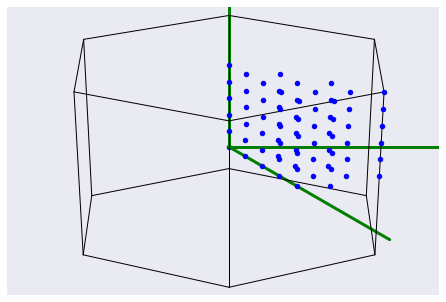

In [5]:
ddb.qpoints.plot();

Note that the DDB file does not contain any information about the value of ngqpt because
one can merge an arbitrary list of q-points in the same DDB.
The algorithms implemented in anaddb, however, need to know the divisions 
to compute integrals in the full BZ 
(this is indeed one of the variables that must be provided by the user in the anaddb input file).

AbiPy uses a heuristic method to guess the q-mesh from this scattered list of q-points
so that you do not need to specify this parameter when calling anaddb: 

In [6]:
ddb.guessed_ngqpt

array([ 9,  9, 10])

<div class="alert alert-warning" role="alert">
If the guess is wrong, you will need to manually set this attribute to the correct value of `ngqpt` before
invoking anaddb from python.
This could happen if you have merged DDB files computed with $q$-points that do not belong to same grid. 
</div>

To test whether the DDB file contains the entries associated to $\epsilon^{\infty}_{\alpha\beta}$ and $Z^*_{\kappa,\alpha\beta}$, use:

In [7]:
print("Contains macroscopic dielectric tensor:", ddb.has_epsinf_terms())
print("Contains Born effective charges:", ddb.has_bec_terms())

Contains macroscopic dielectric tensor: True
Contains Born effective charges: True


Metadata are stored in the header of the DDB file.
AbiPy parses this initial section and stores the values in a dict-like object.
Let us print a sorted list with all the keys in the header: 

In [8]:
from pprint import pprint
pprint(sorted(list(ddb.header.keys())))

['acell',
 'amu',
 'dfpt_sciss',
 'dilatmx',
 'ecut',
 'ecutsm',
 'intxc',
 'iscf',
 'ixc',
 'kpt',
 'kptnrm',
 'lines',
 'natom',
 'nband',
 'ngfft',
 'nkpt',
 'nspden',
 'nspinor',
 'nsppol',
 'nsym',
 'ntypat',
 'occ',
 'occopt',
 'rprim',
 'spinat',
 'symafm',
 'symrel',
 'tnons',
 'tolwfr',
 'tphysel',
 'tsmear',
 'typat',
 'usepaw',
 'version',
 'wtk',
 'xred',
 'zion',
 'znucl']


and use the standard syntax for dictionaries to access the keys:

In [9]:
print("This DDB has been generated with ecut", ddb.header["ecut"], "Ha and nsym", ddb.header["nsym"])

This DDB has been generated with ecut 44.0 Ha and nsym 12


We can also print the DDB object to get a summary of the most important parameters and dimensions:

In [10]:
print(ddb)   

# If more info is needed use: 
# print(ddb.to_string(verbose=1)

================================= File Info =================================
Name: mp-1009129-9x9x10q_ebecs_DDB
Directory: /home/jovbever/Codes/abipy/abipy/data
Size: 218.73 kb
Access Time: Wed Jan 29 14:00:11 2020
Modification Time: Tue Oct 15 10:34:37 2019
Change Time: Tue Oct 15 10:34:37 2019

================================= Structure =================================
Full Formula (Mg1 O1)
Reduced Formula: MgO
abc   :   2.908638   2.908638   2.656848
angles:  90.000000  90.000000 120.000000
Sites (2)
  #  SP           a         b    c
---  ----  --------  --------  ---
  0  Mg    0         0         0
  1  O     0.333333  0.666667  0.5

Abinit Spacegroup: spgid: 0, num_spatial_symmetries: 12, has_timerev: True, symmorphic: False

================================== DDB Info ==================================

Number of q-points in DDB: 72
guessed_ngqpt: [ 9  9 10] (guess for the q-mesh divisions made by AbiPy)
ecut = 44.000000, ecutsm = 0.000000, nkpt = 405, nsym = 12, usepaw = 0


If you are a terminal aficionado, remember that one can use the 
[abiopen.py](http://abinit.github.io/abipy/scripts/abiopen.html) script 
to open the DDB file directly from the shell and generate a jupyter notebook with the `-nb` option.
For a quick visualization script use [abiview.py](http://abinit.github.io/abipy/scripts/abiview.html).

## Invoking Anaddb from the DdbFile object 
[[back to top](#top)]

The `DdbFile` object provides specialized methods to invoke anaddb and 
compute important physical properties such as the phonon band structure, the phonon density of states, etc.
All these methods have a name that begins with the `ana*` prefix followed by a verb (`anaget`, `anacompare`).
These specialized methods 

- build the anaddb input file 
- run anaddb
- parse the netcdf files produced by the Fortran code
- build and return [AbiPy objects](http://abinit.github.io/abipy/api/dfpt_api.html) that can be used to plot/analyze the data.

Note that in order to run anaddb from AbiPy, you need a manager.yml with configuration options.
For further details, please consult the 
[TaskManager documentation](http://abinit.github.io/abipy/workflows/taskmanager.html).

The python API is flexible and exposes several anaddb input variables.
The majority of the arguments have default values covering the most common cases
so that you will need to specify these arguments explicitly only if the default behavior does not suit your needs.
The most important parameters to remember are:

* **ndivsm**: Number of divisions used for the smallest segment of the high-symmetry q-path.
* **nqsmall**: Defines the q-mesh for the phonon DOS in terms of
     the number of divisions used to sample the smallest reciprocal lattice vector. 0 to disable DOS computation.
* **lo_to_splitting**: Activate the computation of the frequencies in the $q\rightarrow 0$ limit with the inclusion of the non-analytical term (requires **dipdip** 1 and DDB with $Z^*_{\kappa,\alpha\beta}$ and $\epsilon^{\infty}_{\alpha\beta}$).

The high-symmetry q-path is automatically selected assuming the structure
fulfills the conventions introduced by [Setyawan and Curtarolo](https://arxiv.org/abs/1004.2974)
but you can also specify your own q-path if needed.

## Plotting phonon bands and DOS
[[back to top](#top)]

To compute phonon bands and DOS, use:

In [11]:
# Call anaddb to compute phonon bands and DOS. Return PHBST and PHDOS netcdf files.
phbstnc, phdosnc = ddb.anaget_phbst_and_phdos_files(
    ndivsm=20, nqsmall=20, lo_to_splitting=True, asr=2, chneut=1, dipdip=1, dos_method="tetra")

# Extract phbands and phdos from the netcdf object.
phbands = phbstnc.phbands
phdos = phdosnc.phdos

Let us have a look at the high symmetry q-path automatically selected by AbiPy with:

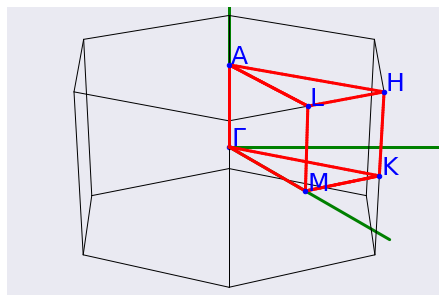

In [12]:
phbands.qpoints.plot();

and plot the phonon bands along this path with:

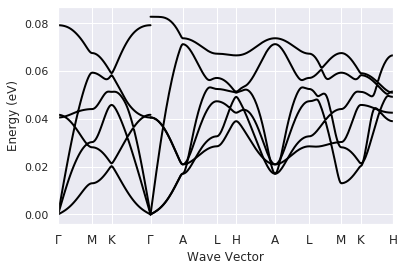

In [13]:
phbands.plot();

Note the discontinuity of the optical modes when we cross the $\Gamma$ point.
In heteropolar semiconductors, indeed, the dynamical matrix is non-analytical for $q \rightarrow 0$.
Since `lo_to_splitting ` was set to True, AbiPy has activated the calculation of the phonon frequencies 
for all the $q \rightarrow \Gamma$ directions present in the path.

There are several band crossings and anti-crossings hence it's not easy
to understand how the branches should be connected.
Fortunately, there is a heuristic method to **estimate** band connection from 
the overlap of the eigenvectors at adjacent q-points. 
To connect the modes and plot the phonon branches with different colors, use:

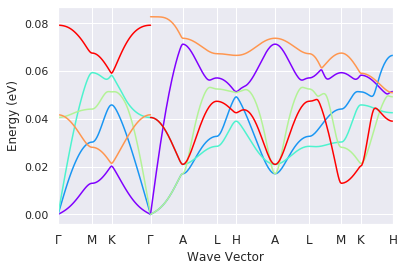

In [14]:
phbands.plot_colored_matched();

<div class="alert alert-warning" role="alert">
This heuristic method may fail so the results should be analyzed critically (especially
when there are non-analytic branches crossing $\Gamma$).
Besides, the algorithm is sensitive to the k-path resolution
thus it is recommended to check the results by increasing the number of points per segment.
</div>

To plot the DOS, $g(\omega)$, and the integrated $IDOS(\omega) = \int^{\omega}_{-\infty} g(\omega')\,d\omega'$, use:

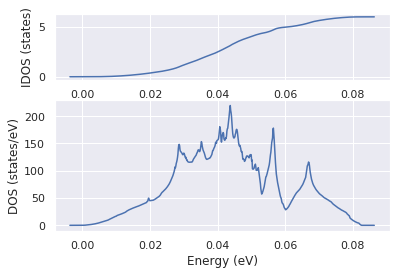

In [15]:
phdos.plot();

Note how the phonon DOS integrates to $3 * N_{atom} = 6$

To plot the phonon bands and the DOS on the same figure use:

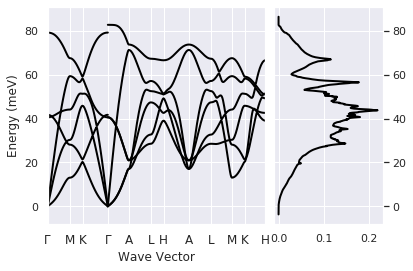

In [16]:
phbands.plot_with_phdos(phdos, units="meV");

## Fatbands and projected DOS
[[back to top](#top)]

The `phbands` object stores the phonon displacements, $\vec{d}_{q\nu}$ and 
the eigenvectors, $\vec{\epsilon}_{q\nu}$ 
obtained by diagonalizing the dynamical matrix $D(q)$.

\begin{equation}
D(q) \vec{\epsilon}_{q\nu} = \omega_{q\nu}^2 \vec{\epsilon}_{q\nu}
\end{equation}

We can therefore use the eigenvectors (or the displacements) to associate 
a width to the different bands (a.k.a. fatbands).
This width gives us a qualitative understanding of the vibrational mode: what are the atomic types involved in
the vibrations at a given energy, their direction of oscillation and the amplitude (related to the displacement).

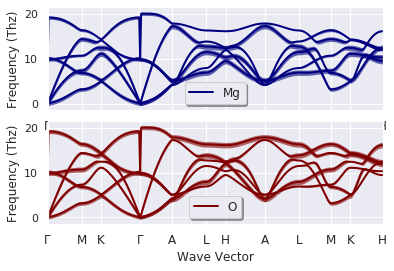

In [17]:
# NB: LO-TO is not available in fatbands
phbands.plot_fatbands(use_eigvec=True, units="Thz");

To plot the fatbands with the type-projected DOS stored in `phdocsnc` use:

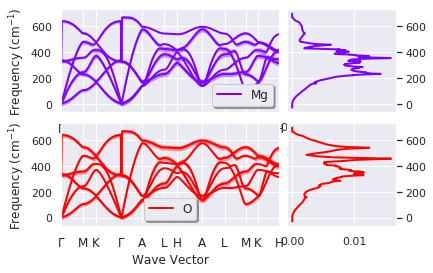

In [18]:
phbands.plot_fatbands(phdos_file=phdosnc, colormap="rainbow", alpha=0.4, units="cm-1");

We can also plot the PJDOS summed over directions and atomic types without fatbands with the command:

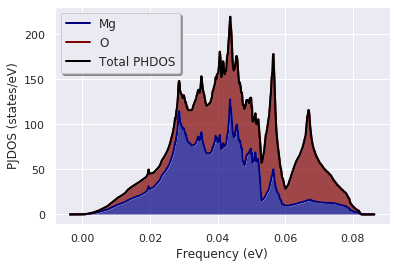

In [19]:
phdosnc.plot_pjdos_type();

The netcdf file contains the individual contributions to the total DOS
for each atomic site and the three cartesian directions.
So there are several quantities we can plot to understand the vibrational spectrum of our systems.
For example, we can decide to sum over all atoms of the same type while keeping 
the dependence on the Cartesian direction:

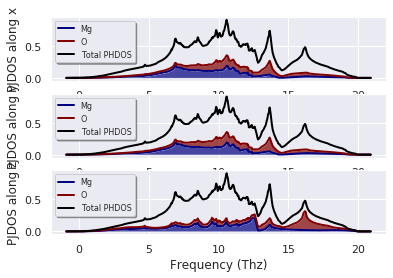

In [20]:
phdosnc.plot_pjdos_cartdirs_type(units="Thz");

This analysis tells us that the peak at ~16 Thz mainly consists of oxygen vibrations along z. 
We could now extend this analysis by looking at the contributions arising from the different sites with: 

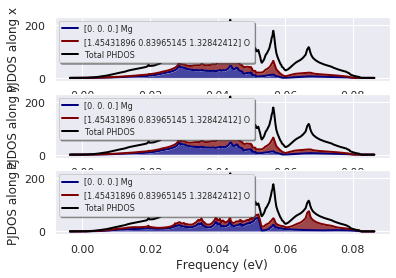

In [21]:
phdosnc.plot_pjdos_cartdirs_site(view="inequivalent", units="eV", stacked=True);

but we prefer to stop here and discuss other tools that can be used to analyze individual phonon modes.

## Visualizing atomic displacements
[[back to top](#top)]

In you need to visualize the lattice vibrations in 3D to gain a better insight 
about the nature of the phonon modes you may want to use the
[phononwebsite](http://henriquemiranda.github.io/phononwebsite/).
One can either convert the out_PHBST.nc produced by anaddb into json format
and upload it to the phononwebsite server or, alternatively, open the terminal and
execute the AbiPy script:

    abiview.py ddb out_DDB --phononwebsite
    
to automate the entire process (replace out_DDB with the name of your DDB file).

Note that there are other AbiPy methods that are quite handy if we need to investigate the nature of the
phonon modes at a particular q-point without a 3D visualization tool.
For example, it is possible to analyze the contribution given by the different types of atoms 
to the phonon displacements at a given q-point with:

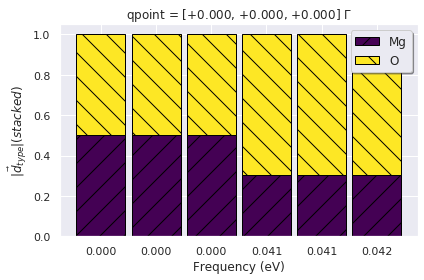

In [22]:
phbands.plot_phdispl(qpoint=(0, 0, 0), tight_layout=True);

As expected the first three (acoustic) modes have zero frequency and 
the two atoms oscillate with the same amplitude.
These modes indeed correspond to a rigid translation of the crystal hence
the amplitude (and the direction) does not depend on the atomic site.
The other three optical modes are (almost) degenerate, while LO-TO splitting should be present, but this is due to the fact
that we are using the frequencies at the $\Gamma$ point without the inclusion of the non-analytical term.

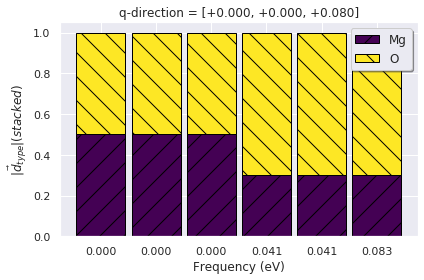

In [23]:
phbands.plot_phdispl((0, 0, 0.1), is_non_analytical_direction=True, tight_layout=True);

To project the phonon displacements along the three cartesian directions, use:

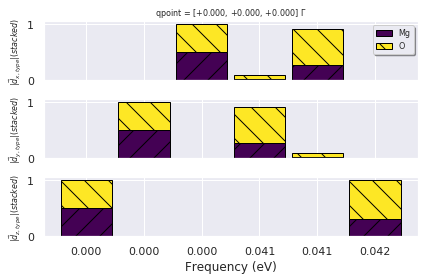

In [24]:
phbands.plot_phdispl_cartdirs(qpoint=(0, 0, 0.0), tight_layout=True);

This plot confirms that the first three modes correspond to a rigid translation along x, y and z, respectively.

## Analyzing the breaking of the acoustic sum rule
[[back to top](#top)]
    
Due to the invariance of the system under an *infinitesimal* rigid translation, the frequency of the lowest 
three modes at $\Gamma$ should be zero.
Unfortunately, all the terms that are evaluated on the real-space FFT mesh 
(e.g. $V_{xc}$, non-linear core-correction) break this kind of translational invariance.
The error depends on several factors: the density of the FFT mesh, 
pseudopotentials with hard model core charges, XC functional, etc.) 
Note that it is not always possible to reduce the error to zero by just increasing the convergence parameters
but fortunately it is possible to restore the acoustic sum rule via the `asr` input variable.

One can easily compare the phonons bands obtained with different values of ``asr`` with:

In [25]:
asr_plotter = ddb.anacompare_asr()

This method invokes anaddb with different values of `asr` and returns a plotter object
we can call to compare the phonon band structures:

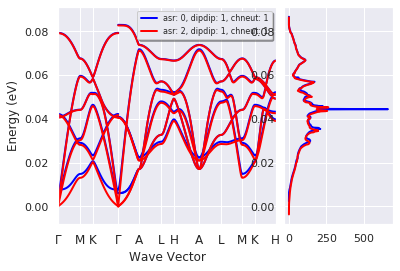

In [26]:
asr_plotter.combiplot();

Now we can perform a similar test for the treatment of the non-analytical term in the $q \rightarrow 0$ limit.
We compute the phonon band dispersion for dipdip in [0, 1] and compare the results on the same figure with the commands:

In [27]:
dipdip_plotter = ddb.anacompare_dipdip(nqsmall=0)

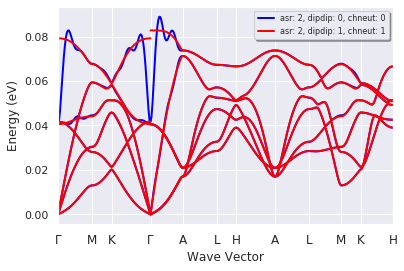

In [28]:
dipdip_plotter.combiplot();

The figure above shows that the (Fourier interpolated) bands obtained with dipdip = 0 
have unphysical oscillations around the $\Gamma$ point.
These oscillation are due to the long-range behavior in real space of the interatomic force constants
in heteropolar semiconductors.
The correct description of this long-range term without dipdip = 1 
would require using an extremely dense q-point mesh in the DFPT calculation.

With dipdip = 1, on the other hand, we can model this long-range behavior in terms of a dipole-dipole
interaction involving the Born effective charges and the macroscopic dielectric tensor.
This allows us to decompose the full dynamical matrix into:

\begin{equation} 
D(q) = D^{sr}(q) + D^{dip-dip}(q) 
\end{equation}

The analytical part of the dynamical matrix, $D^{sr}(q)$, is short-ranged and can be Fourier-interpolated 
with a relatively coarse q-mesh. 
Then the model for the non-analytical term, $D^{dip-dip}(q)$, is added back to the interpolated matrix to get
the full dynamical matrix.
This procedure solves the problem with the unphysical oscillations and is required to describe 
correctly the non-analytical behavior of the optical modes for $q \rightarrow 0$.

## Computing DOS with different q-meshes
[[back to top](#top)]

Phonon DOS and derived quantites (e.g. thermodynamic properties) are sensitive to the BZ sampling
and dense meshes may be required to converge the final results.

The method `anacompare_phdos` provides a simple interface to 
compare phonon DOS computed with different $q$-meshes. 
We only need to provide a list of integers (`nqsmalls`). Each integer defines the number of divisions used to 
sample the smallest reciprocal lattice vector while the other two vectors are sampled such 
that proportions are preserved. 

To calculate three phonon DOS with increasing number of q-points use:

In [29]:
res = ddb.anacompare_phdos(nqsmalls=[8, 12, 24])

The return value is a named tuple with the phonon DOSes in res.phdoses while res.plotter
is PhononDosPlotter.
We can easily compare our results with:

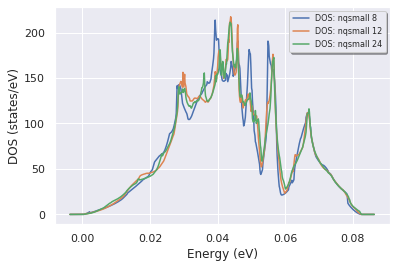

In [30]:
res.plotter.combiplot();

## Thermodynamic properties in the harmonic approximation
[[back to top](#top)]

The thermodynamic properties of an ensemble of non-interacting phonons can be 
expressed in terms of integrals of the phonon DOS $g(\omega)$ using:

\begin{equation} %\label{eq:helmholtz}
\Delta F = 3nNk_BT\int_{0}^{\omega_L}\text{ln}\left(2\text{sinh}\frac{\hbar\omega}{2k_BT}\right)g(\omega)d\omega
\end{equation}

\begin{equation} %\label{eq:free_en}
\Delta E = 3nN\frac{\hbar}{2}\int_{0}^{\omega_L}\omega\text{coth}\left(\frac{\hbar\omega}{2k_BT}\right)g(\omega)d\omega
\end{equation}

\begin{equation} %\label{eq:c_v}
C_v = 3nNk_B\int_{0}^{\omega_L}\left(\frac{\hbar\omega}{2k_BT}\right)^2\text{csch}^2\left(\frac{\hbar\omega}{2k_BT}\right)g(\omega)d\omega
\end{equation}


\begin{equation} %\label{eq:entropy}
S = 3nNk_B\int_{0}^{\omega_L}\left(\frac{\hbar\omega}{2k_BT}\text{coth}\left(\frac{\hbar\omega}{2k_BT}\right) - \text{ln}\left(2\text{sinh}\frac{\hbar\omega}{2k_BT}\right)\right)g(\omega)d\omega,
\end{equation}

where $k_B$ is the Boltzmann constant.
This should represent a reasonable approximation especially in the low-temperature 
regime in which anharmonic effects can be neglected.   

Let's plot the vibrational contributions to the thermodynamic properties as function of temperature $T$:

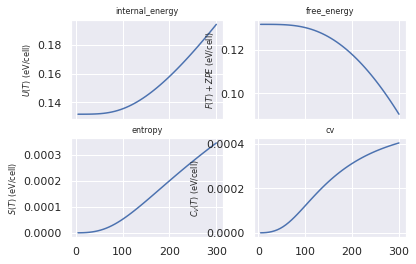

In [31]:
phdos.plot_harmonic_thermo();

and the zero-point energy $\dfrac{1}{2 N_q} \sum_{q\nu} \omega_{q\nu}$

In [32]:
zpe = phdos.zero_point_energy
print("Zero-point energy", zpe, zpe.to("Ha"))

Zero-point energy 0.1317356775059661 eV 0.00484119689478803 Ha


To get the free energy for a range of temperatures in Kelvin degrees, use:

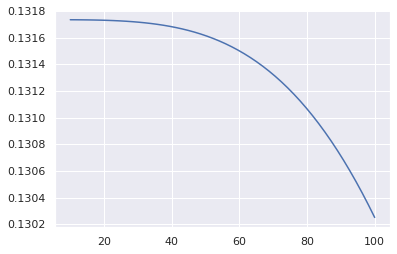

In [33]:
f = phdos.get_free_energy(tstart=10, tstop=100)
f.plot();

## Macroscopic dielectric tensor and Born effective charges
[[back to top](#top)]

 Let us call anaddb to compute the electronic contribution to the macroscopic dielectric tensor,  $\epsilon^{\infty}_{\alpha\beta}$, and the Born effective charges $Z^*_{\kappa,\alpha\beta}$:

In [34]:
emacro, becs = ddb.anaget_epsinf_and_becs(chneut=1)

Note the use of `chneut` to enforce charge neutrality.

In [35]:
emacro

,x,y,z
x,3.438497,0.000000,0.000000
y,0.000000,3.438497,0.000000
z,0.000000,0.000000,3.499416


In [36]:
becs

,element,site_index,frac_coords,cart_coords,wyckoff,xx,yy,zz,yz,xz,xy
0,Mg,0,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",1a,1.98721,1.98721,2.10659,0.0,0.0,0.0
1,O,1,"[0.33333, 0.66667, 0.5]","[1.45432, 0.83965, 1.32842]",1d,-1.98721,-1.98721,-2.10659,0.0,0.0,0.0


In the computation of the low-frequency (infrared) dielectric tensor, $\epsilon^{0}_{\alpha\beta}$, 
one has to include the response of the ions, whose motion will be triggered by the electric field.
One can show that: 

\begin{equation} %\label{eq:dielectric}
\epsilon^{0}_{\alpha\beta}(\omega) = \epsilon^{\infty}_{\alpha\beta} + 4\pi\sum_m\frac{S_{m,\alpha\beta}}{(\omega^{\Gamma}_m - \omega)^2}.
\end{equation}

where $\omega^{\Gamma}_m$ are the phonon frequencies at the center of the BZ and $S_{m,\alpha\beta}$
is the so-called mode-oscillator strengh tensor that depends on the phonon displacement 
and the Born effective charges.

To compute the dielectric tensor using the data stored in the DDB file, use:

In [37]:
dtgen = ddb.anaget_dielectric_tensor_generator()

In [38]:
# call print to get useful information
print(dtgen)

================================= Structure =================================
Full Formula (Mg1 O1)
Reduced Formula: MgO
abc   :   2.908638   2.908638   2.656848
angles:  90.000000  90.000000 120.000000
Sites (2)
  #  SP           a         b    c
---  ----  --------  --------  ---
  0  Mg    0         0         0
  1  O     0.333333  0.666667  0.5

Abinit Spacegroup: spgid: 0, num_spatial_symmetries: 12, has_timerev: True, symmorphic: False

============================ Oscillator strength ============================
Real part in Cartesian coordinates. a.u. units; 1 a.u. = 253.2638413 m3/s2. Set to zero below 1.00e-06.
                          xx                      yy                     zz   yz   xz   xy
mode                                                                                      
0                        0.0                     0.0                    0.0  0.0  0.0  0.0
1                        0.0                     0.0                    0.0  0.0  0.0  0.0
2      

To compute the tensor for a given frequency:

In [39]:
e0 = dtgen.tensor_at_frequency(0)
print(e0)

[[ 1.31018619e+01+0.02381961j  2.54893071e-16+0.j
   1.47502725e-25+0.j        ]
 [ 0.00000000e+00+0.j          1.31018619e+01+0.02381961j
  -2.55482215e-25+0.j        ]
 [-3.68756813e-25+0.j         -1.27741107e-25+0.j
   1.37789476e+01+0.02465278j]]


To plot the frequency dependence with a damping factor of 1e-4 eV (phonon linewidth):

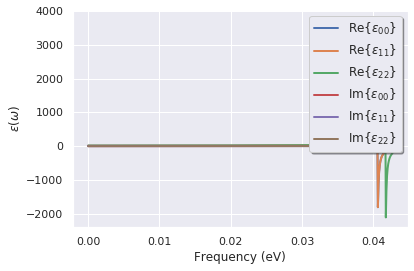

In [67]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

fig = dtgen.plot(w_max=None, gamma_ev=1e-4, component='diag', units='eV')
# fig.axes[0].get_legend().remove()
# fig.axes[0].get_legend().remove()
# legend = legend(loc='upper left')
# fig.show()
# fig.canvas.draw()
# plt.show();

# clear_output(wait=True)
# plt.plot()

In [62]:


# fig.axes[0].get_legend().remove()
# fig.canvas.draw()
# plt.show();

## Using `DdbRobot` to perform convergence studies
[[back to top](#top)]

A `DdbRobot` receives a list of DDB files and provides methods 
to construct [pandas dataframes](https://pandas.pydata.org/pandas-docs/stable/10min.html)
and analyze the results of multiple calculations.
DdbRobots, in particular, are extremely useful to study the convergence of the phonon frequencies with respect to some computational parameters e.g. the number of k-points and the electronic smearing in metallic systems.

In this example, we are interested in the effect of the k-point sampling and the smearing parameter
on the vibrational properties of magnesium diboride.
$MgB_2$ is a metallic system with a critical temperature of 39 K that is the highest among conventional 
(phonon-mediated) superconductors. 
We use precomputed DDB files obtained by running GS+DFPT calculations with different values 
of `nkpt` and `tsmear`. 

Let's build our `DdbRobot` object with:

In [68]:
import os
paths = [
    #"mgb2_444k_0.01tsmear_DDB",
    #"mgb2_444k_0.02tsmear_DDB",
    #"mgb2_444k_0.04tsmear_DDB",
    "mgb2_888k_0.01tsmear_DDB",
    "mgb2_888k_0.02tsmear_DDB",
    "mgb2_888k_0.04tsmear_DDB",
    "mgb2_121212k_0.01tsmear_DDB",
    "mgb2_121212k_0.02tsmear_DDB",
    "mgb2_121212k_0.04tsmear_DDB",
]

paths = [os.path.join(abidata.dirpath, "refs", "mgb2_phonons_nkpt_tsmear", f) for f in paths]

robot = abilab.DdbRobot.from_files(paths)
robot

Label                                                                             Relpath
--------------------------------------------------------------------------------  --------------------------------------------------------------------------------
../../abipy/abipy/data/refs/mgb2_phonons_nkpt_tsmear/mgb2_888k_0.01tsmear_DDB     ../../abipy/abipy/data/refs/mgb2_phonons_nkpt_tsmear/mgb2_888k_0.01tsmear_DDB
../../abipy/abipy/data/refs/mgb2_phonons_nkpt_tsmear/mgb2_888k_0.02tsmear_DDB     ../../abipy/abipy/data/refs/mgb2_phonons_nkpt_tsmear/mgb2_888k_0.02tsmear_DDB
../../abipy/abipy/data/refs/mgb2_phonons_nkpt_tsmear/mgb2_888k_0.04tsmear_DDB     ../../abipy/abipy/data/refs/mgb2_phonons_nkpt_tsmear/mgb2_888k_0.04tsmear_DDB
../../abipy/abipy/data/refs/mgb2_phonons_nkpt_tsmear/mgb2_121212k_0.01tsmear_DDB  ../../abipy/abipy/data/refs/mgb2_phonons_nkpt_tsmear/mgb2_121212k_0.01tsmear_DDB
../../abipy/abipy/data/refs/mgb2_phonons_nkpt_tsmear/mgb2_121212k_0.02tsmear_DDB  ../../abipy/abipy/data/refs/mgb2_phonons_nkpt_tsmear/mgb2_121212k_0.02tsmear_DDB
../../abipy/abipy/data/refs/mgb2_phonons_nkpt_tsmear/mgb2_121212k_0.04tsmear_DDB  ../../abipy/abipy/data/refs/mgb2_phonons_nkpt_tsmear/mgb2_121212k_0.04tsmear_DDB

The [abicomp.py](http://abinit.github.io/abipy/scripts/abicomp.html)
script provides a command line interface to build robots from a list of files/directories
given as arguments


The DDB files are now stored in the robot with a label constructed from the file path.
These labels, however, are not very informative. In principle we would like to have a label
that reflects the value of `(nkpt, tsmear)` also because these labels
will be used to generate the labels in our plots.

Let's fix it with a function that recomputes the labels from the metadata available in ddb.header:

In [69]:
function = lambda ddb: "nkpt: %s, tsmear: %.2f" % (ddb.header["nkpt"], ddb.header["tsmear"])
robot.remap_labels(function);
robot

Label                    Relpath
-----------------------  --------------------------------------------------------------------------------
nkpt: 256, tsmear: 0.01  ../../abipy/abipy/data/refs/mgb2_phonons_nkpt_tsmear/mgb2_888k_0.01tsmear_DDB
nkpt: 256, tsmear: 0.02  ../../abipy/abipy/data/refs/mgb2_phonons_nkpt_tsmear/mgb2_888k_0.02tsmear_DDB
nkpt: 256, tsmear: 0.04  ../../abipy/abipy/data/refs/mgb2_phonons_nkpt_tsmear/mgb2_888k_0.04tsmear_DDB
nkpt: 864, tsmear: 0.01  ../../abipy/abipy/data/refs/mgb2_phonons_nkpt_tsmear/mgb2_121212k_0.01tsmear_DDB
nkpt: 864, tsmear: 0.02  ../../abipy/abipy/data/refs/mgb2_phonons_nkpt_tsmear/mgb2_121212k_0.02tsmear_DDB
nkpt: 864, tsmear: 0.04  ../../abipy/abipy/data/refs/mgb2_phonons_nkpt_tsmear/mgb2_121212k_0.04tsmear_DDB

We are usually interested in the convergence behavior with respect to one 
or two parameters of the calculations. 
Let's build a pandas dataframe with the most important parameters extracted from the DDB header:

In [70]:
robot.get_params_dataframe()

,nkpt,nsppol,ecut,tsmear,occopt,ixc,nband,usepaw
"nkpt: 256, tsmear: 0.01",256,1,35.0,0.01,4,1,8,0
"nkpt: 256, tsmear: 0.02",256,1,35.0,0.02,4,1,8,0
"nkpt: 256, tsmear: 0.04",256,1,35.0,0.04,4,1,8,0
"nkpt: 864, tsmear: 0.01",864,1,35.0,0.01,4,1,8,0
"nkpt: 864, tsmear: 0.02",864,1,35.0,0.02,4,1,8,0
"nkpt: 864, tsmear: 0.04",864,1,35.0,0.04,4,1,8,0


Now we tell the robot to invoke anaddb to compute the phonon bands for all DDB files.
Since we are not interested in the phonon DOS, ``nqsmall`` is set to 0

In [72]:
r = robot.anaget_phonon_plotters(nqsmall=0)
r

dict2namedtuple(phbands_plotter=[0] nkpt: 256, tsmear: 0.01 --> <PhononBands, nk=324, Mg1 B2, id=140369478002392>
[1] nkpt: 256, tsmear: 0.02 --> <PhononBands, nk=324, Mg1 B2, id=140369478173864>
[2] nkpt: 256, tsmear: 0.04 --> <PhononBands, nk=324, Mg1 B2, id=140369477462056>
[3] nkpt: 864, tsmear: 0.01 --> <PhononBands, nk=324, Mg1 B2, id=140369477151488>
[4] nkpt: 864, tsmear: 0.02 --> <PhononBands, nk=324, Mg1 B2, id=140369477273080>
[5] nkpt: 864, tsmear: 0.04 --> <PhononBands, nk=324, Mg1 B2, id=140369477065584>, phdos_plotter=<abipy.dfpt.phonons.PhononDosPlotter object at 0x7faa50dc00b8>)

Now we can plot all the phonon band structures on the same figure with:

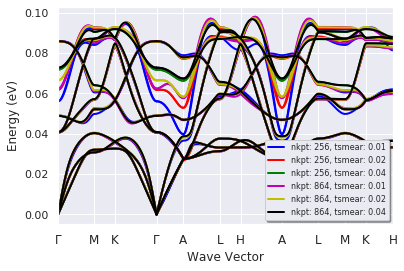

In [73]:
r.phbands_plotter.combiplot();

The plot is a bit crowded. Still, it is clear 
that there are portions of the vibration spectrum that are quite sensitive to the values of (nkpt, tsmear).

In metals, it's common to analyze the convergence of the physical properties by plotting the results
as function of the k-point sampling for fixed value of tsmear.
Let's do something similar for the phonon band structures with the command:

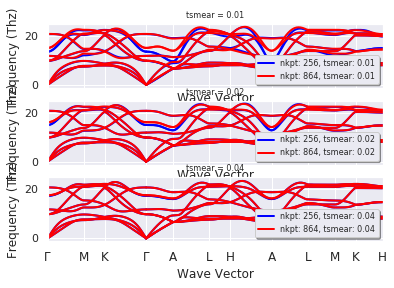

In [74]:
r.phbands_plotter.gridplot_with_hue("tsmear", units="Thz");

Each panel now shows the phonon dispersion computed with different k-point samplings at fixed tsmear.

The results obtained with the largest broadening (0.04 Ha) seem to be converged
but remember that the "converged" result are in principle obtained in the limit $nkpt \rightarrow +\infty$ and $tsmear\rightarrow 0$
(well it's not always possible to reach the mathematical limit so we should try to understand what happens
to our observables when we are **approaching** this limit and if it's possible to find values of (nkpt, tsmear)
that are "close enough" to convergence).

The middle panel reveals that there are two branch (6-7, Python indexing) along $\Gamma-A$ that are quite sensitive to the sampling of the Fermi surface and this picture is confirmed by the first panel obtained with the lowest value of the electronic broadening.

This analysis tells us two things:

* We should analyze in more detail the convergence behavior of these specific branches wrt (nkpt, tsmear)
  to make sure our results are really converged
* The strong variations observed in that particular region of the phonon spectrum could represent the signature
  of an important coupling between these vibrational modes and the electrons on the Fermi surface... 

If you now dig a bit into the scientific literature, you will find that this is the famous $E_{2g}$ branch 
(in-plane oscillations of the two B atoms, twofold degenerate at $\Gamma$) 
that plays an important role in explaining the superconducting behavior of $MgB_2$.

Let's look in more details at the softening at the $\Gamma$ point.
We start by calling get_dataframe_at_qpoint to construct a dataframe 
with the phonon frequencies and the parameters of the calculation 

In [75]:
data = robot.get_dataframe_at_qpoint(qpoint=(0, 0, 0), units="meV", with_geo=False)
data 

,mode0,mode1,mode2,mode3,mode4,mode5,mode6,mode7,mode8,nkpt,nsppol,ecut,tsmear,occopt,ixc,nband,usepaw
"nkpt: 256, tsmear: 0.01",0.0,0.0,0.0,40.517213,40.517213,48.996832,56.043934,56.043934,85.573338,256,1,35.0,0.01,4,1,8,0
"nkpt: 256, tsmear: 0.02",0.0,0.0,0.0,40.605005,40.605005,48.898734,61.746396,61.746396,85.580765,256,1,35.0,0.02,4,1,8,0
"nkpt: 256, tsmear: 0.04",0.0,0.0,0.0,40.772307,40.772307,48.802866,71.729034,71.729034,85.854690,256,1,35.0,0.04,4,1,8,0
"nkpt: 864, tsmear: 0.01",0.0,0.0,0.0,40.834668,40.834668,48.789198,62.305097,62.305097,85.876512,864,1,35.0,0.01,4,1,8,0
"nkpt: 864, tsmear: 0.02",0.0,0.0,0.0,40.753912,40.753912,48.961271,66.425595,66.425595,85.642626,864,1,35.0,0.02,4,1,8,0
"nkpt: 864, tsmear: 0.04",0.0,0.0,0.0,40.773842,40.773842,48.835985,72.698701,72.698701,85.812753,864,1,35.0,0.04,4,1,8,0


and use [seaborn](https://seaborn.pydata.org/) to produce a scatter plot in which the color of the points depends on tsmear:

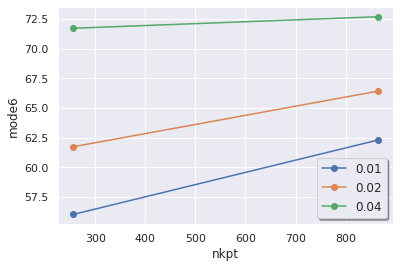

In [76]:
robot.plot_xy_with_hue(data, x="nkpt", y="mode6", hue="tsmear");

A DDbRobot is essential a dictionary of DdbFiles and we can therefore reuse the DdbFile methods to call anaddb.
For example, we said that the two degenerate $E_{2g}$ modes at $\Gamma$ 
involve in-plane oscillations of the two Mg atoms.
Let's check this with:

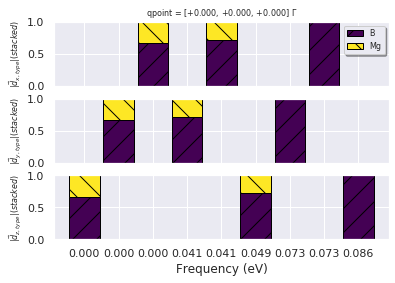

In [77]:
key = "nkpt: 864, tsmear: 0.04"
gamma_point = (0, 0, 0)

phbands_gamma = robot[key].anaget_phmodes_at_qpoint(gamma_point, dipdip=0, lo_to_splitting=False)
phbands_gamma.plot_phdispl_cartdirs(gamma_point);

### How to analyze the converge of $\epsilon^0$, $\epsilon^\infty$ and Born effective charges

Let's assume we have computed the dielectric properties and the Born effective charges for a given
system with different k-meshes and we want to analyze the convergence of the results.
Also in this case, the `DdbRobot` provides methods to automate most of the boring work.

As usual, we start by creating a robot from a list of paths to DDB files.
Here we use three different files produced with 2x2x2, 4x4x4 and 8x8x8 k-meshes.

In [78]:
paths = [
    "out_ngkpt222_DDB", 
    "out_ngkpt444_DDB", 
    "out_ngkpt888_DDB"]

paths = [os.path.join(abidata.dirpath, "refs", "alas_eps_and_becs_vs_ngkpt", f) for f in paths]

alas_robot = abilab.DdbRobot.from_files(paths)
alas_robot

Label                                                                    Relpath
-----------------------------------------------------------------------  -----------------------------------------------------------------------
../../abipy/abipy/data/refs/alas_eps_and_becs_vs_ngkpt/out_ngkpt222_DDB  ../../abipy/abipy/data/refs/alas_eps_and_becs_vs_ngkpt/out_ngkpt222_DDB
../../abipy/abipy/data/refs/alas_eps_and_becs_vs_ngkpt/out_ngkpt444_DDB  ../../abipy/abipy/data/refs/alas_eps_and_becs_vs_ngkpt/out_ngkpt444_DDB
../../abipy/abipy/data/refs/alas_eps_and_becs_vs_ngkpt/out_ngkpt888_DDB  ../../abipy/abipy/data/refs/alas_eps_and_becs_vs_ngkpt/out_ngkpt888_DDB

Now we call `anacompare_epsinf` to create a pandas `Dataframe` with the upper triangle 
of the $\epsilon_{ij}^\infty$ dielectric tensor (Voigt notation) and we add the number of k-points
in the IBZ to the table to facilitate the analysis:

In [79]:
r = alas_robot.anacompare_epsinf(ddb_header_keys="nkpt")
r.df

,xx,yy,zz,yz,xz,xy,formula,chneut,nkpt
0,13.584082,13.584082,13.584082,0.0,0.0,0.0,Al1 As1,1,16
1,9.268425,9.268425,9.268425,0.0,0.0,0.0,Al1 As1,1,128
2,8.873178,8.873178,8.873178,0.0,0.0,0.0,Al1 As1,1,1024


A similar approach can be used to analyze $\epsilon_{ij}^0$

In [80]:
r = alas_robot.anacompare_eps0(ddb_header_keys="nkpt")
r.df

,xx,yy,zz,yz,xz,xy,formula,asr,chneut,nkpt
0,15.884551,15.884551,15.884551,0.0,0.0,0.0,Al1 As1,2,1,16
1,10.839414,10.839414,10.839414,0.0,0.0,0.0,Al1 As1,2,1,128
2,10.415665,10.415665,10.415665,0.0,0.0,0.0,Al1 As1,2,1,1024


Analyzing the convergence of the Born effective charges is a bit more complicated 
because now we have a tensor for each atom in the unit cell:

In [81]:
r = alas_robot.anacompare_becs(ddb_header_keys="nkpt")
r.df

,element,site_index,frac_coords,cart_coords,wyckoff,xx,yy,zz,yz,xz,xy,formula,chneut,nkpt
0,Al,0,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",1a,2.393991,2.393991,2.393991,0.0,0.0,0.0,Al1 As1,1,16
2,Al,0,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",1a,1.998460,1.998460,1.998460,0.0,0.0,0.0,Al1 As1,1,128
4,Al,0,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",1a,1.972175,1.972175,1.972175,0.0,0.0,0.0,Al1 As1,1,1024
1,As,1,"[0.25, 0.25, 0.25]","[1.40364, 1.40364, 1.40364]",1d,-2.393991,-2.393991,-2.393991,0.0,0.0,0.0,Al1 As1,1,16
3,As,1,"[0.25, 0.25, 0.25]","[1.40364, 1.40364, 1.40364]",1d,-1.998460,-1.998460,-1.998460,0.0,0.0,0.0,Al1 As1,1,128
5,As,1,"[0.25, 0.25, 0.25]","[1.40364, 1.40364, 1.40364]",1d,-1.972175,-1.972175,-1.972175,0.0,0.0,0.0,Al1 As1,1,1024


But we can use the pandas API to select a portion of the data.
The below code, for example, selects the Born effective charges for *As*:

In [82]:
r.df[r.df["site_index"] == 1]

,element,site_index,frac_coords,cart_coords,wyckoff,xx,yy,zz,yz,xz,xy,formula,chneut,nkpt
1,As,1,"[0.25, 0.25, 0.25]","[1.40364, 1.40364, 1.40364]",1d,-2.393991,-2.393991,-2.393991,0.0,0.0,0.0,Al1 As1,1,16
3,As,1,"[0.25, 0.25, 0.25]","[1.40364, 1.40364, 1.40364]",1d,-1.998460,-1.998460,-1.998460,0.0,0.0,0.0,Al1 As1,1,128
5,As,1,"[0.25, 0.25, 0.25]","[1.40364, 1.40364, 1.40364]",1d,-1.972175,-1.972175,-1.972175,0.0,0.0,0.0,Al1 As1,1,1024


<!--- Click [TODO here]() to visualize the vibrational spectrum of $MgB_2$ with phononwebsite -->

[[back to top](#top)]